In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
from glob import glob
import cv2
import os
from tqdm import tqdm
import zipfile

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten
from tensorflow.keras import Model

from fastai.vision.all import *

In [ ]:
!pip install fastai --upgrade
!pip install fastcore --upgrade

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
1.제출하기
2. lafoss 가 만들어둔 Unext50 
3.fast.ai
4. lovasz metric, dice
5. test time augmentation
'''

#### 전체 데이터 불러오기

In [ ]:
!unzip /content/drive/MyDrive/keydney_segmentation/train.zip -d /content/train
!unzip /content/drive/"My Drive"/keydney_segmentation/test.zip -d /content/test

In [2]:
MASKS = '/content/drive/MyDrive/keydney_segmentation/train.csv'
DATA = '/content/train/train/'
OUT_TRAIN = '/content/drive/MyDrive/keydney_segmentation/train_split.zip'
OUT_MASKS = '/content/drive/MyDrive/keydney_segmentation/masks_split.zip'
OUT_TEST = '/content/drive/MyDrive/keydney_segmentation/test_split.zip'

In [13]:
#functions to convert encoding to mask and mask to encoding
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

df_masks = pd.read_csv(MASKS).set_index('id')
df_masks.head()

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,8273094 14 8289273 41 8305453 67 8321632 82 83...


In [ ]:
sz = 256   #the size of tiles
reduce = 4 #reduce the original images by 4 times 
s_th = 40  #saturation blancking threshold
p_th = 200*sz//256 #threshold for the minimum number of pixels

x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        #read image and generate the mask
        img = tiff.imread(os.path.join(DATA,index+'.tiff'))
        if len(img.shape) == 5:
            img = np.transpose(img.squeeze(), (1,2,0))
        mask = enc2mask(encs,(img.shape[1],img.shape[0]))

        #add padding to make the image dividable into tiles
        shape = img.shape
        pad0 = (reduce*sz - shape[0]%(reduce*sz))%(reduce*sz)
        pad1 = (reduce*sz - shape[1]%(reduce*sz))%(reduce*sz)
        img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                    constant_values=0)
        mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2]],
                    constant_values=0)

        #split image and mask into tiles using the reshape+transpose trick
        img = cv2.resize(img,(img.shape[1]//reduce,img.shape[0]//reduce),
                         interpolation = cv2.INTER_AREA)
        img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
        img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

        mask = cv2.resize(mask,(mask.shape[1]//reduce,mask.shape[0]//reduce),
                          interpolation = cv2.INTER_NEAREST)
        mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz)
        mask = mask.transpose(0,2,1,3).reshape(-1,sz,sz)

        #write data
        for i,(im,m) in enumerate(zip(img,mask)):
            #remove black or gray images based on saturation check
            hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            if (s>s_th).sum() <= p_th or im.sum() <= p_th: continue
            
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{index}_{i}.png', im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{i}.png', m)

#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)




  0%|          | 0/8 [00:00<?, ?it/s]


 12%|█▎        | 1/8 [00:18<02:07, 18.16s/it]


 25%|██▌       | 2/8 [00:29<01:36, 16.03s/it]


 38%|███▊      | 3/8 [02:06<03:22, 40.51s/it]


 50%|█████     | 4/8 [02:50<02:46, 41.54s/it]


 62%|██████▎   | 5/8 [03:20<01:53, 37.89s/it]


 75%|███████▌  | 6/8 [05:05<01:56, 58.02s/it]


 88%|████████▊ | 7/8 [05:51<00:54, 54.54s/it]


100%|██████████| 8/8 [06:53<00:00, 51.70s/it]

mean: [0.65459856 0.48386562 0.69428385] , std: [0.15167958 0.23584107 0.13146145]


In [ ]:
columns, rows = 4,4
idx0 = 20
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import cv2
import gc
import random
from albumentations import *
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / union
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
        ious.append(iou)
    ious = map(mean, zip(*ious)) # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    #loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    loss = torch.dot(F.elu(errors_sorted)+1, Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, only_present=False, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), only_present=only_present)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), only_present=only_present)
    return loss


def lovasz_softmax_flat(probas, labels, only_present=False):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    C = probas.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float() # foreground for class c
        if only_present and fg.sum() == 0:
            continue
        errors = (Variable(fg) - probas[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [5]:
bs = 64
nfolds = 4
fold = 0
SEED = 2020
TRAIN = '/content/train_split'
MASKS = '/content/masks_split'
LABELS = '/content/drive/MyDrive/keydney_segmentation/train.csv'
NUM_WORKERS = 4

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

In [ ]:
!unzip /content/drive/"My Drive"/keydney_segmentation/train_split.zip -d /content/train_split
!unzip /content/drive/"My Drive"/keydney_segmentation/masks_split.zip -d /content/masks_split

In [8]:
mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : 
        img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self, fold=fold, train=True, tfms=None):
        ids = pd.read_csv(LABELS).id.values
        kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        self.fnames = [fname for fname in os.listdir(TRAIN) if fname.split('_')[0] in ids]
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask)
    
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)

In [ ]:
#example of train images with masks
ds = HuBMAPDataset(tfms=get_aug())
dl = DataLoader(ds,batch_size=64,shuffle=False,num_workers=NUM_WORKERS)
imgs,masks = next(iter(dl))

plt.figure(figsize=(16,16))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
del ds,dl,imgs,masks

In [9]:
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
            for in_ch, out_ch in zip(input_channels, output_channels)])
        
    def forward(self, xs:list, last_layer):
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
               for i,(c,x) in enumerate(zip(self.convs, xs))]
        hcs.append(last_layer)
        return torch.cat(hcs, dim=1)

class UnetBlock(Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
        self.conv2 = ConvLayer(nf, nf, norm_type=None,
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
        
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        self.aspps = nn.ModuleList(self.aspps)
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                        nn.BatchNorm2d(mid_c), nn.ReLU())
        out_c = out_c if out_c is not None else mid_c
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
        self._init_weight()

    def forward(self, x):
        x0 = self.global_pool(x)
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [10]:
class UneXt50(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
                           'resnext50_32x4d_ssl')
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x

#split the model to encoder and decoder for fast.ai
split_layers = lambda m: [list(m.enc0.parameters())+list(m.enc1.parameters())+
                list(m.enc2.parameters())+list(m.enc3.parameters())+
                list(m.enc4.parameters()),
                list(m.aspp.parameters())+list(m.dec4.parameters())+
                list(m.dec3.parameters())+list(m.dec2.parameters())+
                list(m.dec1.parameters())+list(m.fpn.parameters())+
                list(m.final_conv.parameters())]

In [11]:
class Dice_soft(Metric):
    def __init__(self, axis=1): 
        self.axis = axis 
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()
    @property
    def value(self): return 2.0 * self.inter/self.union if self.union > 0 else None
    
# dice with automatic threshold selection
class Dice_th(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.05), axis=1): 
        self.axis = axis
        self.ths = ths
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 
                2.0*self.inter/self.union, torch.zeros_like(self.union))
        return dices.max()

In [12]:
#iterator like wrapper that returns predicted and gt masks
class Model_pred:
    def __init__(self, model, dl, tta:bool=True, half:bool=False):
        self.model = model
        self.dl = dl
        self.tta = tta
        self.half = half
        
    def __iter__(self):
        self.model.eval()
        name_list = self.dl.dataset.fnames
        count=0
        with torch.no_grad():
            for x,y in iter(self.dl):
                x = x.cuda()
                if self.half: x = x.half()
                p = self.model(x)
                py = torch.sigmoid(p).detach()
                if self.tta:
                    #x,y,xy flips as TTA
                    flips = [[-1],[-2],[-2,-1]]
                    for f in flips:
                        p = self.model(torch.flip(x,f))
                        p = torch.flip(p,f)
                        py += torch.sigmoid(p).detach()
                    py /= (1+len(flips))
                if y is not None and len(y.shape)==4 and py.shape != y.shape:
                    py = F.upsample(py, size=(y.shape[-2],y.shape[-1]), mode="bilinear")
                py = py.permute(0,2,3,1).float().cpu()
                batch_size = len(py)
                for i in range(batch_size):
                    taget = y[i].detach().cpu() if y is not None else None
                    yield py[i],taget,name_list[count]
                    count += 1
                    
    def __len__(self):
        return len(self.dl.dataset)
    
class Dice_th_pred(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.01), axis=1): 
        self.axis = axis
        self.ths = ths
        self.reset()
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self,p,t):
        pred,targ = flatten_check(p, t)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 2.0*self.inter/self.union, 
                            torch.zeros_like(self.union))
        return dices
    
def save_img(data,name,out):
    data = data.float().cpu().numpy()
    img = cv2.imencode('.png',(data*255).astype(np.uint8))[1]
    out.writestr(name, img)

In [13]:
def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1.0 - targets))

In [14]:
dice = Dice_th_pred(np.arange(0.2,0.7,0.01))
for fold in range(nfolds):
    ds_t = HuBMAPDataset(fold=fold, train=True, tfms=get_aug())
    ds_v = HuBMAPDataset(fold=fold, train=False)
    data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=bs,
                num_workers=NUM_WORKERS,pin_memory=True).cuda()
    model = UneXt50().cuda()
    learn = Learner(data, model, loss_func=symmetric_lovasz,
                metrics=[Dice_soft(),Dice_th()], 
                splitter=split_layers).to_fp16(clip=0.5)
    
    #start with training the head
    learn.freeze_to(-1) #doesn't work
    for param in learn.opt.param_groups[0]['params']:
        param.requires_grad = False
    learn.fit_one_cycle(6, lr_max=0.5e-2)

    #continue training full model
    learn.unfreeze()
    learn.fit_one_cycle(32, lr_max=slice(2e-4,2e-3),
        cbs=SaveModelCallback(monitor='dice_th',comp=np.greater))
    torch.save(learn.model.state_dict(),f'model_{fold}.pth')
    
    #model evaluation on val and saving the masks
    mp = Model_pred(learn.model,learn.dls.loaders[1])
    with zipfile.ZipFile('val_masks_tta.zip', 'a') as out:
        for p in progress_bar(mp):
            dice.accumulate(p[0],p[1])
            save_img(p[0],p[2],out)
    gc.collect()

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


TypeError: ignored

#### 가공 데이터 불러오기

In [ ]:
!unzip /content/drive/"My Drive"/keydney_segmentation/train_split.zip -d /content/train_split
!unzip /content/drive/"My Drive"/keydney_segmentation/masks_split.zip -d /content/masks_split
!unzip /content/drive/"My Drive"/keydney_segmentation/test_split.zip -d /content/test_split

Archive:  /content/drive/My Drive/keydney_segmentation/train_split.zip
replace /content/train_split/2f6ecfcdf_00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/My Drive/keydney_segmentation/masks_split.zip
replace /content/masks_split/2f6ecfcdf_00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/My Drive/keydney_segmentation/test_split.zip
replace /content/test_split/afa5e8098_00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_files = glob('/content/train_split/*')
mask_files = glob('/content/masks_split/*')
test_files = glob('/content/test_split/*')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/keydney_segmentation/train.csv')
train

In [ ]:
metadata = pd.read_csv('/content/drive/MyDrive/keydney_segmentation/HuBMAP-20-dataset_information.csv')
metadata.head()

In [ ]:
MASKS = '/content/drive/MyDrive/keydney_segmentation/train.csv'
DATA = '/content/train/train/'
OUT_TRAIN = '/content/drive/MyDrive/keydney_segmentation/train_split.zip'
OUT_MASKS = '/content/drive/MyDrive/keydney_segmentation/masks_split.zip'
OUT_TEST = '/content/drive/MyDrive/keydney_segmentation/test_split.zip'

In [ ]:
#functions to convert encoding to mask and mask to encoding
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, shape, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

df_masks = pd.read_csv(MASKS).set_index('id')
df_masks.head()

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,8273094 14 8289273 41 8305453 67 8321632 82 83...


# train/mask data crop

In [ ]:
train_files = glob('/content/train/train/*')

In [ ]:
train_index = []
for i in train_files:
    if i[-4:] == 'tiff':
        train_index.append(i[-14:-5])

In [ ]:
from PIL import Image
def image_crop():

    with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
    zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
        for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
            img = tiff.imread('/content/train/train/'+ index + '.tiff')
            if len(img.shape) == 5:
                img = np.transpose(img.squeeze(), (1,2,0))
            mask = enc2mask(encs,(img.shape[1],img.shape[0]))
            (img_h, img_w, channel) = img.shape
            print(img.shape)
            print(mask.shape)

            # crop 할 사이즈 : grid_w, grid_h
            grid_w = 256 # crop width
            grid_h = 256 # crop height
            range_w = (int)(img_w/grid_w)
            range_h = (int)(img_h/grid_h)
            print(range_w, range_h)

            i = 0
            for w in range(range_w):
                for h in range(range_h):
                    # 가로 세로 시작, 가로 세로 끝
                    crop_image = img[h*grid_h:(h+1)*(grid_h),w*grid_w:(w+1)*(grid_w),:]
                    crop_mask = mask[h*grid_h:(h+1)*(grid_h),w*grid_w:(w+1)*(grid_w)]
                    # crop_img = Image.fromarray(crop_image)

                    im = cv2.imencode('.png',cv2.cvtColor(crop_image, cv2.COLOR_RGB2BGR))[1]
                    img_out.writestr(index + "_" +  "{}.png".format("{0:05d}".format(i)), im)

                    mas = cv2.imencode('.png',crop_mask)[1]
                    mask_out.writestr(index + "_" + "{}.png".format("{0:05d}".format(i)), mas)

                    i += 1
 
if __name__ == '__main__':
    image_crop()

  0%|          | 0/8 [00:00<?, ?it/s]

(31278, 25794, 3)
100 122


 12%|█▎        | 1/8 [01:17<09:03, 77.70s/it]

(18484, 13013, 3)
50 72


 25%|██▌       | 2/8 [01:43<06:12, 62.16s/it]

(34940, 49548, 3)
193 136


 38%|███▊      | 3/8 [04:38<08:00, 96.09s/it]

(25784, 34937, 3)
136 100


 50%|█████     | 4/8 [06:06<06:14, 93.56s/it]

(16180, 27020, 3)
105 63


 62%|██████▎   | 5/8 [06:59<04:03, 81.33s/it]

(38160, 39000, 3)
152 149


 75%|███████▌  | 6/8 [09:41<03:31, 105.55s/it]

(30440, 22240, 3)
86 118


 88%|████████▊ | 7/8 [10:53<01:35, 95.60s/it] 

(26780, 32220, 3)
125 104


100%|██████████| 8/8 [12:34<00:00, 94.25s/it]


# crop 이미지 복원 시키기

In [ ]:
rows = []
for i in range(range_h):
    for j in range(range_w):
        if j == 0:
            temp_arr = temp_image_array[i]
        else:
            temp_arr = np.concatenate((temp_arr, temp_image_array[j]), axis = 0)
    rows.append(temp_arr)

for i, vector in enumerate(rows):
    if i == 0:
        restored_img = vector
    else:
        restored_img = np.concatenate((temp_arr, vector), axis = 1)

## test data crop

In [ ]:
test_files = glob('/content/test/test/*')

In [ ]:
test_index

['afa5e8098', 'c68fe75ea', 'b2dc8411c', 'b9a3865fc', '26dc41664']

In [ ]:
from PIL import Image
def image_crop():

    with zipfile.ZipFile(OUT_TEST, 'w') as img_out:
        for index in tqdm(test_index):
            img = tiff.imread('/content/test/test/'+ index + '.tiff')
            if len(img.shape) == 5:
                img = np.transpose(img.squeeze(), (1,2,0))
            (img_h, img_w, channel) = img.shape
            print(img.shape)

            # crop 할 사이즈 : grid_w, grid_h
            grid_w = 256 # crop width
            grid_h = 256 # crop height
            range_w = (int)(img_w/grid_w)
            range_h = (int)(img_h/grid_h)
            print(range_w, range_h)

            i = 0
            for w in range(range_w):
                for h in range(range_h):
                    # 가로 세로 시작, 가로 세로 끝
                    crop_image = img[h*grid_h:(h+1)*(grid_h),w*grid_w:(w+1)*(grid_w),:]
                    # crop_img = Image.fromarray(crop_image)

                    im = cv2.imencode('.png',cv2.cvtColor(crop_image, cv2.COLOR_RGB2BGR))[1]
                    img_out.writestr(index + "_" +  "{}.png".format("{0:05d}".format(i)), im)


                    i += 1
 
if __name__ == '__main__':
    image_crop()


  0%|          | 0/5 [00:00<?, ?it/s]

(36800, 43780, 3)
171 143



 20%|██        | 1/5 [01:46<07:06, 106.53s/it]

(26840, 49780, 3)
194 104



 40%|████      | 2/5 [04:09<05:52, 117.58s/it]

(14844, 31262, 3)
122 57



 60%|██████    | 3/5 [04:48<03:07, 93.84s/it] 

(31295, 40429, 3)
157 122



 80%|████████  | 4/5 [06:55<01:43, 103.72s/it]

(38160, 42360, 3)
165 149



100%|██████████| 5/5 [09:30<00:00, 114.13s/it]


### mask가 있는 사진만 골라내기

In [ ]:
info_id = []
for i, mask in tqdm(enumerate(mask_files)):
    temp_mask = np.array(Image.open(mask))
    if temp_mask.sum() != 0:
        info_id.append(i)

print(len(info_id))

108059it [01:54, 940.74it/s] 

7201


In [ ]:
info_img = [train_files[i] for i in info_id] #train image
info_mask = [mask_files[i] for i in info_id] #mask image

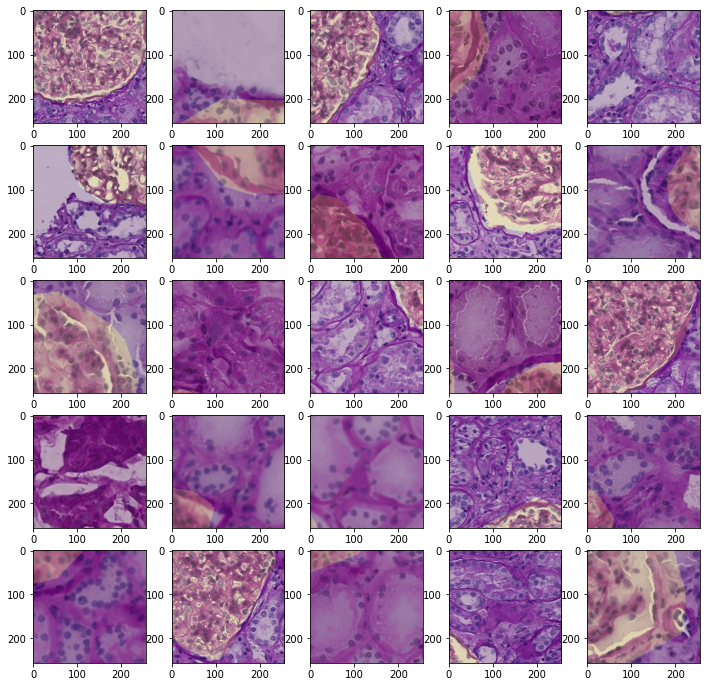

In [ ]:
cols, rows = 5,5
fig = plt.figure(figsize = (12,12))
idx0 = 900
for i in range(cols):
    for j in range(rows):
        idx = i+j*cols
        img = Image.open(info_img[idx + idx0])
        mask = Image.open(info_mask[idx+ idx0])

        fig.add_subplot(rows, cols, idx+1)
        plt.imshow(img)
        plt.imshow(mask, alpha = 0.2)
plt.show()

# numpy로 저장

In [ ]:
img_array = []
for i in tqdm(info_img):
    img = Image.open(i)
    img_array.append(np.array(img))
img_array = np.array(img_array)  

mask_array = []
for i in tqdm(info_mask):
    mask = Image.open(i)
    mask_array.append(np.array(mask))
    # mask_array.append(np.array(mask).reshape(256*256))
mask_array = np.array(mask_array, dtype = np.float32)

100%|██████████| 7201/7201 [00:02<00:00, 2640.38it/s]


# Modeling

In [ ]:
def base_model(input_layer, start_neurons):
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)

    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='sigmoid')(uconv1)
    # output_layer = Flatten()(output_layer)
    
    return output_layer

input_layer = Input((256, 256, 3))
output_layer = base_model(input_layer,64)

In [ ]:
def dice_score_loss(y_true, y_pred):
  numerator = 2. * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)
  return tf.reduce_mean(1 - numerator / denominator)


def dice_coef(y_true, y_pred):
    return 1-dice_score_loss(y_true, y_pred)

In [ ]:
model = Model(input_layer,output_layer)
model.compile(optimizer='adam', loss=dice_score_loss, metrics=[dice_coef])

In [ ]:
EPOCHS = 20
batch_size = 32
# train_img, train_mask, val_img, val_mask = train_test_split(img_array, mask_array, test_size = 0.2)

# train_dataset = tf.data.Dataset.from_tensor_slices((img_array, mask_array))
# train_dataset = get_training_dataset(train_dataset)

# validation_dataset = tf.data.Dataset.from_tensor_slices(val_img, val_mask)
# validation_dataset = get_validation_dataset(validation_dataset, batch_size = batch_size)

model_history = model.fit(x = img_array, y = mask_array, validation_split=0.3 ,batch_size = batch_size, epochs=EPOCHS)

Epoch 1/20
158/158 [==============================] - 65s 410ms/step - loss: 0.4178 - dice_coef: 0.5825 - val_loss: 0.5626 - val_dice_coef: 0.4360
Epoch 2/20
158/158 [==============================] - 63s 401ms/step - loss: 0.3762 - dice_coef: 0.6240 - val_loss: 0.5243 - val_dice_coef: 0.4743
Epoch 3/20
158/158 [==============================] - 63s 401ms/step - loss: 0.3554 - dice_coef: 0.6448 - val_loss: 0.5611 - val_dice_coef: 0.4375
Epoch 4/20
158/158 [==============================] - 63s 401ms/step - loss: 0.3465 - dice_coef: 0.6537 - val_loss: 0.4406 - val_dice_coef: 0.5580
Epoch 5/20
158/158 [==============================] - 63s 401ms/step - loss: 0.3234 - dice_coef: 0.6767 - val_loss: 0.4264 - val_dice_coef: 0.5723
Epoch 6/20
158/158 [==============================] - 63s 401ms/step - loss: 0.3109 - dice_coef: 0.6892 - val_loss: 0.5425 - val_dice_coef: 0.4561
Epoch 7/20
158/158 [==============================] - 63s 401ms/step - loss: 0.3001 - dice_coef: 0.6996 - val_loss: 0.

KeyboardInterrupt: ignored

# pred

In [ ]:
test_26dc41664 = []
for i, test_img in tqdm(enumerate(test_files)):
    if '26dc41664' in test_img:
        temp_img = np.array(Image.open(test_img))
        if temp_img.sum() != 0:
            test_26dc41664.append(temp_img)

test_26dc41664 = np.array(test_26dc41664)
test_26dc41664.shape

95322it [01:07, 1419.27it/s]


(20829, 1, 256, 256, 3)

In [ ]:
def testGenerator():
    for img_name in test_files:
        if '26dc41664' in img_name:
            test_array = np.array(Image.open(img_name))
            if test_array.sum() != 0:
                yield (test_array)

test_dataset = tf.data.Dataset.from_generator(testGenerator, tf.float32, tf.TensorShape([256,256,3]))
test_dataset = test_dataset.batch(64).prefetch(1)

In [ ]:
pred = model.predict(test_dataset)
pred = (pred > 0.5).astype(np.int8)

In [ ]:
def rle_encode_less_memory(pixels):
    #watch out for the bug
    pixels = pixels.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return encs.join(str(x) for x in runs)

In [ ]:
encs = ''
for i in pred[:10]:
    encs = rle_encode_less_memory(i)

In [ ]:
def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

In [ ]:
del mask_out

In [ ]:
sz = 256   #the size of tiles
reduce = 4 #reduce the original images by 4 times
TH = 0.39  #threshold for positive predictions
DATA = '../input/hubmap-kidney-segmentation/test/'
MODELS = [f'../input/hubmap-fast-ai-starter/model_{i}.pth' for i in range(4)]
df_sample = pd.read_csv('../input/hubmap-kidney-segmentation/sample_submission.csv')
bs = 64
NUM_WORKERS = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')